<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep conv net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an ipython notebook via learningsuite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 20% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracy
* 10% Reach 85% validation accuracy from parts 1-3
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

**DONE:**
* Watch tutorial

In [8]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [10]:
# Use the dataset class you created in lab2
class ConvNetwork(nn.Module):
  def __init__(self, dataset):
    
    super(ConvNetwork,self).__init__()

    x,y = dataset[0]
    c, h, w = x.size()
    output = 10

    self.net = nn.Sequential(
        nn.Conv2d(c, 10, (3,3), padding=(1,1)),
        nn.Conv2d(10, output, (28,28), padding=(0,0)))

  def forward(self, x):
    return self.net(x).squeeze(2).squeeze(2)


# Create a dataset class that extends the torch.utils.data Dataset class here
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root, 
                                      train=train,
                                      transform=transforms.ToTensor(),
                                      download=True)
    
  def __getitem__(self, i):
    x,y = self.data[i]
    return x, y

  def __len__(self):
    return len(self.data)

# Instantiate the train and validation sets
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist')
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

# Instantiate your model and loss and optimizer functions
model = ConvNetwork(train_dataset)
model = model.cuda()

# Instantiate your data loaders
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset, 
                          batch_size=42, 
                          pin_memory=True)
val_loader = DataLoader(val_dataset, 
                               batch_size=42,
                               pin_memory=True)

losses = []
validations = []

for epoch in range(0):
  loop = tqdm(total=len(train_loader), position=0, leave=False)

  for batch, (x,y_truth) in enumerate(train_loader):
    x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)

    optimizer.zero_grad()
    y_hat = model(x)

    loss = objective(y_hat,y_truth)

    loss.backward()

    losses.append(loss.item())
    accuracy = (y_hat.argmax(1) == y_truth).float().mean()
    loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}'.format(epoch, loss.item(), accuracy))
    loop.update(1)

    optimizer.step()

    if batch % 500 == 0:
      val = np.mean([objective(model(x.cuda()), y.cuda()).item()
                      for x, y in val_loader])
      validations.append((len(losses), val))

  loop.close()

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

**TODO:**

* CrossEntropyLoss 

**DONE:**
* Conv2D
___

### Part 2
Implement a few initialization strategies which can include Xe initialization
(sometimes called Xavier), Orthogonal initialization, and uniform random.
You can specify which strategy you want to use with a parameter. 



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**

**DONE:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform


In [11]:
class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, 
               gnore_index=-100, reduce=None, reduction='mean'):
    super(CrossEntropyLoss, self).__init__()
  
  def forward(self, y_hat, y_truth):
    x = torch.arange(y_hat.size(0))
    y = y_truth

    hat = y_hat

    values = y_hat[x,y]
    values = torch.exp(values)
    hatexp = torch.exp(hat)
    soft = values / hatexp.sum(1, keepdim=True)
    log = -1 * torch.log(soft)

    return loss


class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, 
               padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros',
               device=None, dtype=None, activation=0):
    
    self.__dict__.update(locals())
    super(Conv2d, self).__init__()

    self.weight = Parameter(torch.Tensor(out_channels, in_channels, 
                               kernel_size[0], kernel_size[1]))
    self.bias = Parameter(torch.Tensor(out_channels))
    

    # Uniform initalization
    if activation == 0:
      self.weight.data.uniform_(-1,1)
    # Xavier initialization
    elif activation == 1:
      W = np.random.randn(out_channels, in_channels, kernel_size[0], kernel_size[1]) / np.sqrt(in_channels/2)
      self.weight.data = torch.from_numpy(W.astype(np.float32))
    # Orthogonal initialization
    else:
      X = np.random.random((out_channels, in_channels * kernel_size[0] * kernel_size[1]))
      U, _, Vt = np.linalg.svd(X, full_matrices=False)
      np.allclose(np.dot(Vt, Vt.T), np.eye(Vt.shape[0]))
      self.weight.data = torch.from_numpy(Vt.reshape((out_channels, in_channels, kernel_size[0], kernel_size[1])).astype(np.float32))

    self.bias.data.uniform_(0,0)

  
  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, 
                    self.dilation, self.groups)

In [12]:
class ConvNetwork(nn.Module):
  def __init__(self, dataset, activation_type):
    
    super(ConvNetwork,self).__init__()

    x,y = dataset[0]
    c, h, w = x.size()
    output = 10

    print(activation_type)


    self.net = nn.Sequential(
        Conv2d(c, 8, (3,3), padding=(1,1), activation=activation_type),
        nn.ReLU(),
        Conv2d(8, output, (28,28), padding=(0,0), activation=activation_type))

  def forward(self, x):
    return self.net(x).squeeze(2).squeeze(2)


In [13]:
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root, 
                                      train=train,
                                      transform=transforms.ToTensor(),
                                      download=True)
    
  def __getitem__(self, i):
    x,y = self.data[i]
    return x, y

  def __len__(self):
    return len(self.data)


# Initialize Datasets
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist')
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)


# Initialize DataLoaders
train_loader = DataLoader(train_dataset, 
                          batch_size=42, 
                          pin_memory=True)
val_loader = DataLoader(val_dataset, 
                               batch_size=42,
                               pin_memory=True)


# Initialize Model - 0 for uniform weights, 1 for Xavier and 2 for Orthogonal
model = ConvNetwork(train_dataset, 2)
model = model.cuda()


# Initialize Objective and Optimizer and other parameters
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


losses = []
validations = []
accuracy_vals = []

2


In [14]:
# Run your training and validation loop and collect stats

for epoch in range(5):
  loop = tqdm(total=len(train_loader), position=0, leave=False)

  for batch, (x,y_truth) in enumerate(train_loader):
    x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)

    optimizer.zero_grad()
    y_hat = model(x)

    loss = objective(y_hat,y_truth)
    loss.backward()

    losses.append(loss.item())
    accuracy = (y_hat.argmax(1) == y_truth).float().mean()
    #accuracy_vals.append(accuracy)
    loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}'.format(epoch, loss.item(), accuracy))
    loop.update(1)

    optimizer.step()

    if batch % 500 == 0:
      val = np.mean([objective(model(x.cuda()), y.cuda()).item()
                      for x, y in val_loader])
      validations.append((len(losses), val))
      accuracy_vals.append(accuracy)

  loop.close()





___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

Once you've experimented with multiple network setups and the different initialization strategies, plot the best-performing experiment here. You should be able to exceed 85% accuracy on the validation set.

**TODO:**


**DONE:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time
* Print out number of parameters in the model 
* Plot experiment results with 85% or better validation accuracy


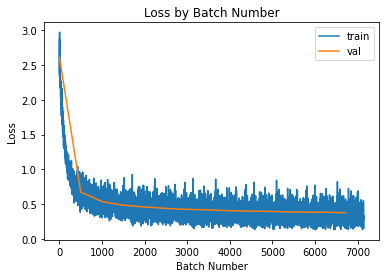

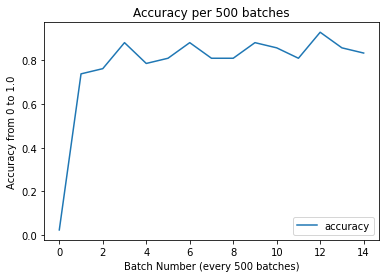

In [15]:

# Go back up and try a few different networks and initialization strategies

# I had a hard time getting a network with lots of parameters, I am still 
# getting used to understanding how to calculate the channels/padding/kernel 
# size for each new layer. I had good results in terms of accuracy with the 
# 2 layer set up, orthogonal initialization, and a ReLU layer between it, 
# running for 5 epochs.

# Plot loss if you want
a, b = zip(*validations)
plt.plot(losses,label='train')
plt.plot(a,b, label='val')
plt.title('Loss by Batch Number')
plt.ylabel('Loss')
plt.xlabel('Batch Number')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(accuracy_vals, label='accuracy')
plt.ylabel('Accuracy from 0 to 1.0')
plt.xlabel('Batch Number (every 500 batches)')
plt.title('Accuracy per 500 batches')
plt.legend()
plt.show()



In [16]:
## Compute and print the number of parameters in the model
sum = 0
for p in model.parameters():
  layerparams = 1
  
  for s in p.size():
    layerparams *= s

  sum += layerparams


print("Total Parameters: " + str(sum))

Total Parameters: 62810


___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(3, 3), padding=(1, 1))**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **(out_channels=65, kernel_size=(3, 3), padding=(2, 2))**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **(out_channels=7, kernel_size=(3, 3), padding=(6, 6))**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5, 5), padding=(2, 2))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5, 5), padding=(3, 3))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5, 5), padding=(9, 9))**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out_channels=10, kernel_size=(5, 3), padding=(1, 0))**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5, 3), padding=(2, 1))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5, 3), padding=(3, 2))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5, 3), padding=(9, 8))**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **(out_channels=10, kernel_size=(2, 4), padding=(0, 0))**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(1, 1), padding=(0, 0))**

**TODO:**

**DONE:**
* Answer all the questions above


In [17]:
# Write some test code for checking the answers for these problems (example shown in the video)
print("Testing code for 3x3 kernel\n")
# (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
c = nn.Conv2d(3,10,kernel_size=(3,3), padding=(0,0))
print(c(torch.zeros(1,3,10,10)).size())

#(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : Your answer in bold here
c = nn.Conv2d(3, 22, kernel_size=(3,3), padding=(1,1))
print(c(torch.zeros(1,3,10,10)).size())

#(c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : Your answer in bold here
c = nn.Conv2d(3, 65, kernel_size=(3,3), padding=(2,2))
print(c(torch.zeros(1,3,10,10)).size())

#(c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : Your answer in bold here
c = nn.Conv2d(3, 7, kernel_size=(3,3), padding=(6,6))
print(c(torch.zeros(1,3,10,10)).size())

print("\nTesting code for 5x5 kernel\n")

#c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
c = nn.Conv2d(3,10,kernel_size=(5,5), padding=(1,1))
print(c(torch.zeros(1,3,10,10)).size())

#(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : Your answer in bold here
c = nn.Conv2d(3,100,kernel_size=(5,5), padding=(2,2))
print(c(torch.zeros(1,3,10,10)).size())

#(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : Your answer in bold here
c = nn.Conv2d(3,23,kernel_size=(5,5), padding=(3,3))
print(c(torch.zeros(1,3,10,10)).size())

#(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : Your answer in bold here
c = nn.Conv2d(3,5,kernel_size=(5,5), padding=(9,9))
print(c(torch.zeros(1,3,10,10)).size())


print("\nTesting code for 5x3 kernel\n")

#(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : Your answer in bold here
c = nn.Conv2d(3, 10, kernel_size=(5,3), padding=(1,0))
print(c(torch.zeros(1,3,10,10)).size())

#(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : Your answer in bold here
c = nn.Conv2d(3, 100, kernel_size=(5,3), padding=(2,1))
print(c(torch.zeros(1,3,10,10)).size())

#(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : Your answer in bold here
c = nn.Conv2d(3, 23, kernel_size=(5,3), padding=(3,2))
print(c(torch.zeros(1,3,10,10)).size())

#(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : Your answer in bold here
c = nn.Conv2d(3, 5, kernel_size=(5,3), padding=(9,8))
print(c(torch.zeros(1,3,10,10)).size())

print("\nTesting code for unknown kernel size\n")

#(c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : Your answer in bold here
c = nn.Conv2d(3, 10, kernel_size=(2,4), padding=(0,0))
print(c(torch.zeros(1,3,10,10)).size())

#(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : Your answer in bold here
c = nn.Conv2d(3, 22, kernel_size=(1,1), padding=(0,0))
print(c(torch.zeros(1,3,10,10)).size())



#Conv2d(c, 8, (3,3), padding=(1,1)

Testing code for 3x3 kernel

torch.Size([1, 10, 8, 8])
torch.Size([1, 22, 10, 10])
torch.Size([1, 65, 12, 12])
torch.Size([1, 7, 20, 20])

Testing code for 5x5 kernel

torch.Size([1, 10, 8, 8])
torch.Size([1, 100, 10, 10])
torch.Size([1, 23, 12, 12])
torch.Size([1, 5, 24, 24])

Testing code for 5x3 kernel

torch.Size([1, 10, 8, 8])
torch.Size([1, 100, 10, 10])
torch.Size([1, 23, 12, 12])
torch.Size([1, 5, 24, 24])

Testing code for unknown kernel size

torch.Size([1, 10, 9, 7])
torch.Size([1, 22, 10, 10])
